In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statistics import stdev
import math

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [73]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

In [58]:
class RandomForest:
    def __init__(self, sample_size, n_trees = 10 , min_samples_leaf = 5, max_depth = 4, max_features = None):
        self.n_trees, self.sample_size , self.min_samples_leaf, self.max_depth, self.max_features = n_trees, sample_size, min_samples_leaf, max_depth, max_features
        self.trees = [self.create_tree() for _ in range(self.n_trees)]
        
    def create_tree(self):
        
        return DecisionTree(min_samples_leaf = self.min_samples_leaf, max_depth = self.max_depth, max_features = self.max_features)
    
    def fit(self, X, y):    
        for tree in self.trees:
            random_idxs = np.random.permutation(X.shape[0])[:self.sample_size]
            tree.var_split(X.iloc[random_idxs, :], y[random_idxs]) 
    
    def predict(self, x):
      #  for t in self.trees:
       #     print('prediction: '+str(t.predict(x)))
        return np.mean([t.predict(x) for t in self.trees], axis = 0)
    
    def plot_pdp(self, X_valid, y_valid, feature_name, n_clusters = 0): pass
    
    def find_feature_importances(self, X, y): pass
    
    

In [7]:
%load_ext cython

In [61]:
%%cython
import math
import numpy as np
def stddev(cnt, values, sum1):
    return math.sqrt(math.fabs((values/cnt) - (sum1/cnt)**2))

class DecisionTree:
    
    def __init__(self, int min_samples_leaf = 3, int max_depth = 4, int level = 0, max_features = None):
        self.min_samples_leaf, self.max_depth = min_samples_leaf, max_depth
        self.score = float('inf')
        self.value = 0.0
        self.leftTree , self.rightTree, self.split_val, self.split_feature  = None, None, None, None
        self.level = level
        self.max_features = max_features
       
        
    @property 
    def is_leaf(self):
        return self.score == float('inf')
    
   
    def find_better_split(self, x, y, int ind):
    
        x1 = x.values[:, ind]
        inds = np.argsort(x1, axis = 0)
        sorted_y, sorted_x = y[inds], x1[inds]
        rhs_count, rhs_sum, rhs_sum2  = x.shape[0], sorted_y.sum(), (sorted_y**2).sum() 
        lhs_count, lhs_sum, lhs_sum2 = 0, 0., 0.
      #  print('for '+ str(x.columns[ind]))
        for i in range(0, x.shape[0]-self.min_samples_leaf+1):
            lhs_count, lhs_sum, lhs_sum2 = lhs_count+1, lhs_sum + sorted_y[i], lhs_sum2 + sorted_y[i]**2
            rhs_count, rhs_sum, rhs_sum2 = rhs_count-1, rhs_sum - sorted_y[i], rhs_sum2 - sorted_y[i]**2
            if i < self.min_samples_leaf - 1 or sorted_x[i] == sorted_x[i+1]:
                continue
            updated_score = ((lhs_count * stddev(lhs_count, lhs_sum2, lhs_sum)) + (rhs_count * stddev(rhs_count, rhs_sum2, rhs_sum)))/(x.shape[0])
            #print('score: '+ str(updated_score))
            if updated_score < self.score :
                self.score = updated_score
                self.split_feature = x.columns[ind]
                self.split_val = i
                self.value = (np.mean(y[:i])*i + np.mean(y[i:])*(x.shape[0] - i))/(x.shape[0])
        self.score = self.score
       
        
   
    def var_split(self, x, y):
        
        if x.shape[0] > self.min_samples_leaf and self.level < self.max_depth - 1:
            #find max_features to split on
             
            if self.max_features is not None:
                if self.max_features in ['auto', 'sqrt']:
                    self.max_features = int(math.sqrt(x.shape[1]))
                else:
                    if self.max_features == 'log2':
                        self.max_features = int(np.log(float(x.shape[1]))/np.log(2))
                    else:
                        if isinstance(self.max_features, float):
                            self.max_features = int(self.max_features * x.shape[1])
                        else:
                            self.max_features = x.shape[1]
            else:
                self.max_features = x.shape[1]
            self.max_features = int(self.max_features)
            feature_inds = np.random.permutation(x.shape[1])[:self.max_features] 
            #print('will split on features: '+str(feature_inds))
            feature_inds = [index for index in feature_inds if x.columns[index] != None]
            for ind in feature_inds:
                self.find_better_split(x, y, ind) 
           # print('split on '+ str(self.split_feature)+' with score '+str(self.score) + "at level : "+str(self.level))
            x_lhs, x_rhs = x.iloc[:self.split_val,:], x.iloc[self.split_val:,:]
            self.leftTree = DecisionTree(min_samples_leaf = self.min_samples_leaf, max_depth = self.max_depth, level = self.level + 1)
            self.leftTree.var_split(x_lhs, y[:self.split_val])
            self.rightTree = DecisionTree(min_samples_leaf = self.min_samples_leaf, max_depth = self.max_depth, level = self.level + 1)
            self.rightTree.var_split(x_rhs, y[self.split_val:])
        
        else :
            self.score = float('inf')
            #print('at leaf node : '+str(y))
            y = [val for val in y if val != None]
            self.value = np.mean(y)

        
    def predict_row(self, row):      
        if self.is_leaf: 
            #print('result: ' + str(self.value))
            return self.value
        if row[self.split_feature] < self.split_val:
            return self.leftTree.predict_row(row)
        else:
            return self.rightTree.predict_row(row)
    
           
    def predict(self, X):
        y_pred = []
        for row in range(X.shape[0]):
            y_pred.append(self.predict_row(X.iloc[row, :]))
        return y_pred
        
            
  
    def __repr__(self):
        return "score: " +str(self.score) + " avg: "+str(self.value) +  " split val: " + str(self.split_val) + " split feature : "+ str(self.split_feature)

In [ ]:
def find_better_split()

In [9]:
#class DecisionTree():
 #   def __init__()
train_data = pd.read_csv('../input/train.csv')

train_data, valid_data  = train_test_split(train_data, train_size = 0.7, random_state = 1)

train_cats(train_data)
apply_cats(valid_data, train_data)

X_train, y_train, _ = proc_df(train_data, 'SalePrice', max_n_cat = 7)
X_valid, y_valid, _ = proc_df(valid_data, 'SalePrice', max_n_cat = 7)

y_train = np.log(y_train)
y_valid = np.log(y_valid)

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
feat_imp = rf.feature_importances_
imp = sorted(zip(feat_imp, X_train.columns), reverse = True)
imp[:10]


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[(0.5062031988499395, 'OverallQual'),
 (0.09538686818122935, 'GrLivArea'),
 (0.08274245116948725, 'GarageCars'),
 (0.04041210607299729, '1stFlrSF'),
 (0.040143300476863805, 'GarageArea'),
 (0.03728116614313645, 'TotalBsmtSF'),
 (0.02374448497794605, 'BsmtFinSF1'),
 (0.015883955531646662, 'YearBuilt'),
 (0.013490182175304233, 'LotArea'),
 (0.008396752367148543, 'YearRemodAdd')]

0.15193016432822837
0.20532506871137768


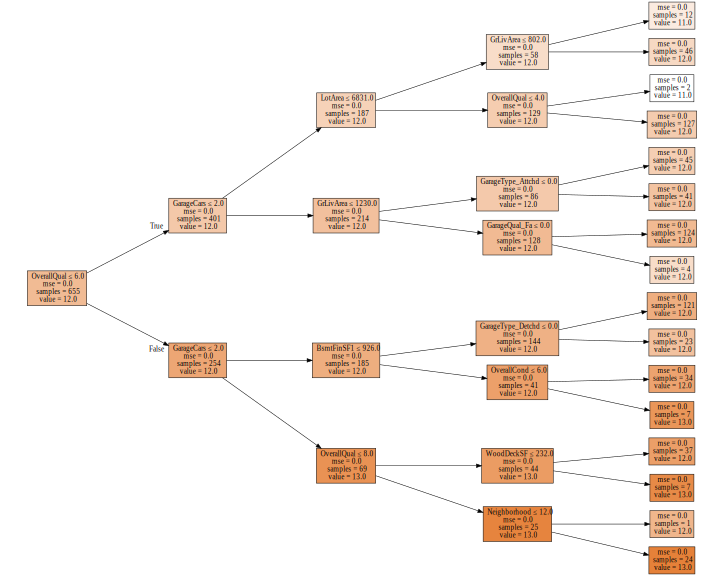

In [10]:
#X_train = X_train[['OverallQual', 'GrLivArea']]
rf_simple = RandomForestRegressor(n_estimators = 5, n_jobs = -1, random_state = 1, max_depth = 4)
rf_simple.fit(X_train, y_train)
print(rmse(y_train, rf_simple.predict(X_train)))
print(rmse(y_valid, rf_simple.predict(X_valid)))
draw_tree(rf_simple[0], df = X_train, ratio = 0.8)



 score: 0.3005888049233399 avg: 12.03497626549539 split val: 233 split feature : FullBath
score: 0.21613523052614408 avg: 12.051192894166917 split val: 9 split feature : GrLivArea
0.3823753517950935
0.43724682831403344


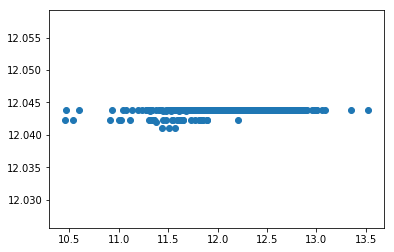

In [62]:
%prun
rf_mine = RandomForest(500, n_trees = 50, min_samples_leaf = 3, max_depth = 6, max_features = 0.5)
rf_mine.fit(X_train, y_train)
print(rf_mine.trees[49])
print(rf_mine.trees[0].leftTree.leftTree.leftTree.leftTree)
print(rmse(y_train, rf_mine.predict(X_train)))
print(rmse(y_valid, rf_mine.predict(X_valid)))
plt.scatter(y_valid, rf_mine.predict(X_valid))

Finding the confidence of a prediction by finding standard deviation of its group.

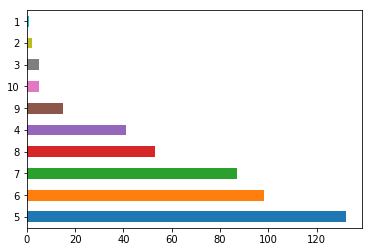

In [63]:

y_pred = np.stack([t.predict(X_valid) for t in rf_mine.trees])
mean_pred, std_dev = np.mean(y_pred[:,0]), np.std(y_pred[:,0])
X_new = X_valid.copy()
X_new['mean_pred'] = mean_pred
X_new['std_dev_pred'] = std_dev
X_new.OverallQual.value_counts().plot.barh()

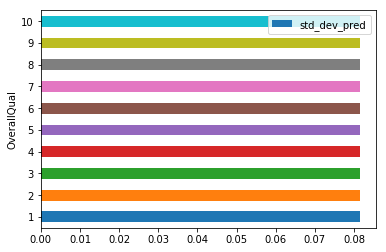

In [64]:
X_new['SalePrice'] = y_valid
flds = ['OverallQual','SalePrice', 'mean_pred', 'std_dev_pred']
overallQual_props = X_new[flds].groupby(['OverallQual'], as_index = False).mean()
overallQual_props
overallQual_props.plot('OverallQual', 'std_dev_pred', 'barh')

Find feature importances

In [ ]:
%%cython
import numpy as np
def find_feature_importances(self, X, y):
    feat_imp = {}
    for ind in range(X.shape[1]):
        X_new = X.copy()
        np.random.shuffle(X_new.values[:, ind])
        y_pred = self.predict(X_new)
        feat_imp[X.columns[ind]] = np.sqrt(np.mean((y - y_pred)**2))
    
    sorted_feat_imp = sorted(zip(feat_imp, X.columns), reverse = True)
    return sorted_feat_imp
    
RandomForest.find_feature_importances = find_feature_importances
idxs = np.random.permutation(X_train.shape[0])[:500]
feature_imp = find_feature_importances(rf_mine, X_train.iloc[idxs, :], y_train[idxs])
feature_imp.plot('barh')


Finding partial feature dependencies and also feature interactions, by keeping other levers constant

In [ ]:
%%cython
def plot_pdp(self, X, y, feature_name, n_clusters = 0):
    feature_id = -1
    for index in range(X.shape[1]):
        if X.columns[index] == feature_name:
            feature_id = index
    for feature_val in X[feature_id].unique():
        X_new = X_valid.copy()
        X_new[feature] = feature_val
        y_pred_val = self.predict(X_new)
        y_pred_vals.append(y_pred_val)
           
        y_pred_mean.append(np.mean(y_pred_val, axis = 0))
        
    plt.plot(y_valid, y_pred_mean)
    y_pred_randoms = np.random.normal(y_pred_vals)[:n_clusters]
    for y_pred in y_pred_randoms:
        plt.plot(y_valid, y_pred)
        
rf_mine.plot_pdp = plot_pdp
idxs = np.random(X_train)[:500]
rf_mine.plot_pdp(X_train[idxs], y_train[idxs], 'OverallQual')
        

In [ ]:
%%cython
def plot_pdp_interaction(X, y, feature_names):
    feature1 = None
    feature2 = None
    for feature in X.columns:
        
        
        

Tree Interpreter and way 2 of Feature Importances. Waterfall Chart